# Visualisation for the local outlier factor
## Made by Yngve Mardal Moe

In [7]:
%matplotlib notebook

from operator import itemgetter

import numpy as np
import scipy
import matplotlib.pyplot as plt

from sklearn.neighbors import LocalOutlierFactor

from ipywidgets import IntSlider, Checkbox, HBox
from IPython.display import display

In [30]:
class LOFVisualiser:
    def __init__(self):
        self.dataset = self._generate_dataset()
        self.distances = scipy.spatial.distance_matrix(self.dataset, self.dataset)
        
        self.idx = 0
        self.previous_k = 3
        
        # Generate matplotlib figure
        self.fig = plt.figure()
        self.sub = self.fig.add_subplot(111)
        self.sub.scatter(self.dataset[:, 0], self.dataset[:, 1], s=5)
        self.fig.canvas.mpl_connect('button_press_event', self.press_button)
        
        # Set up IPython Widgets
        self.k_slider = IntSlider(min=1, max=15, value=3)
        self.k_slider.on_trait_change(self.update_lof_visualisation)
        self.neighbouring_densities = Checkbox(description='Show neighbouring densities')
        self.neighbouring_densities.on_trait_change(self.update_lof_visualisation)
        display(HBox([self.k_slider, self.neighbouring_densities]))
        
        # Prepare to compute the local outlier factor
        self.lof = LocalOutlierFactor(n_neighbors=self.k_slider.value)
        self.lof.fit(self.dataset)
    
    @property
    def current_lof(self):
        """The local outlier factor of the currently selected point.
        """
        if self.previous_k != self.k_slider.value:
            self.lof = LocalOutlierFactor(n_neighbors=self.k_slider.value)
            self.lof.fit(self.dataset)
            
        current_sample = self.dataset[self.idx]
        return -self.lof._decision_function(current_sample.reshape(1, -1))[0]
    
    @staticmethod
    def _generate_dataset():
        """Generate a bimodal dataset with two outliers.
        """
        synthetic_X = 0.7*np.random.randn(100) + 1
        synthetic_Y = 2*np.random.randn(100) + 2

        synthetic_X_2 = 0.2*np.random.randn(50) - 5
        synthetic_Y_2 = 0.4*np.random.randn(50) + 3

        outlier_X = 0.3*np.random.randn(1) - 3
        outlier_Y = 0.3*np.random.randn(1) - 2

        outlier_X_2 = 0.3*np.random.randn(1) - 4.5
        outlier_Y_2 = 0.3*np.random.randn(1) + 1

        return np.stack((np.concatenate((synthetic_X, synthetic_X_2, outlier_X, outlier_X_2)),
                         np.concatenate((synthetic_Y, synthetic_Y_2, outlier_Y, outlier_Y_2))),
                        axis=1)

    def get_kth_nearest(self, idx, k=None):
        """Find the index of the kth nearest neighbour for datapoint number `idx`
        """
        if k is None:
            k = self.k_slider.value
            
        distances = self.distances[idx]
        return sorted(enumerate(distances), key=itemgetter(1))[k][0]

    def find_nearest_idx(self, click_point):
        """Find the nearest datapoint to the clicked position.
        """
        distances = np.linalg.norm(self.dataset - np.reshape(click_point, (1, -1)), axis=1)
        return sorted(enumerate(distances), key=itemgetter(1))[0][0]
    
    def draw_density_circle(self, idx, draw_neighbours=False, plot_radius=True, color='red'):
        """Draw a circle around the given point, radius equal to the distance to the kth neighbour
        """
        k = self.k_slider.value
        distances = self.distances[idx]
        kth_idx = self.get_kth_nearest(idx)
        
        circle = plt.Circle(self.dataset[idx], distances[kth_idx], 
                            fill=False, color=color)
        self.sub.add_artist(circle)
        
        if plot_radius:
            relevant_points = self.dataset[(idx, kth_idx), :]
            self.sub.plot(relevant_points[:, 0], relevant_points[:, 1], color=color)
        
        if draw_neighbours:
            for i in range(1, 1+k):
                ith_nearest_idx = self.get_kth_nearest(idx, i)
                self.draw_density_circle(ith_nearest_idx, draw_neighbours=False,
                                         plot_radius=False, color='green')
        
    def update_lof_visualisation(self):
        """Update the visualisation.
        """
        self.sub.clear()
        self.sub.set_title(f'Local outlier factor: {self.current_lof:.2f}')
        
        self.sub.scatter(self.dataset[:, 0], self.dataset[:, 1], s=5)
        self.sub.scatter(self.dataset[self.idx, 0], self.dataset[self.idx, 1], s=6)
        self.draw_density_circle(self.idx, self.neighbouring_densities.value)
        
    def press_button(self, event):
        """On click events, updates visualisation.
        """
        xy = np.array((event.xdata, event.ydata))
        self.idx = self.find_nearest_idx(xy)
        self.update_lof_visualisation()

<IPython.core.display.Javascript object>


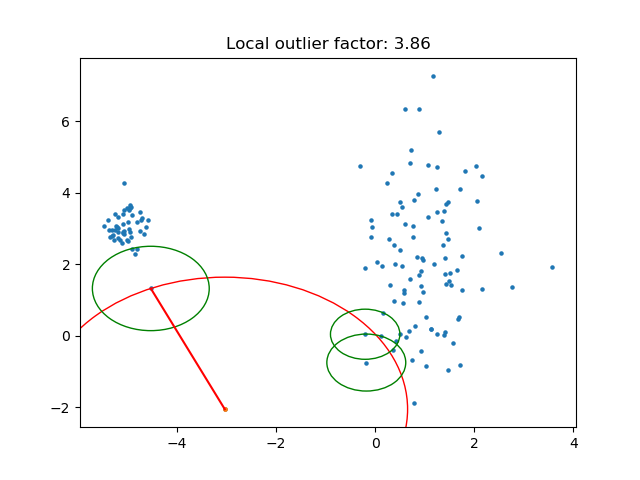

/home/yngve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
/home/yngve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead


A Jupyter Widget

In [31]:
LOFVisualiser()